In [19]:
import os
import cv2
import glob
import pydicom
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from albumentations import Compose, ShiftScaleRotate, Resize, CenterCrop, HorizontalFlip, RandomBrightnessContrast
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from torchvision import transforms

In [12]:
dir_train_img = 'stage_1_train_png_224x'
dir_test_img = 'stage_1_test_png_224x'
dir_csv = 'labels'

train = pd.read_csv(os.path.join(dir_csv, 'stage_2_train.csv'))
test = pd.read_csv(os.path.join(dir_csv, 'stage_2_sample_submission.csv'))
train.head(5)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [13]:
# Split train out into row per image and save a sample

train[['ID', 'Image', 'Diagnosis']] = train['ID'].str.split('_', expand=True)
train = train[['Image', 'Diagnosis', 'Label']]
train.drop_duplicates(inplace=True)
train = train.pivot(index='Image', columns='Diagnosis', values='Label').reset_index()
train['Image'] = 'ID_' + train['Image']
train.head()

Diagnosis,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0


In [14]:
new_train = train[['Image','any']]
new_train

Diagnosis,Image,any
0,ID_000012eaf,0
1,ID_000039fa0,0
2,ID_00005679d,0
3,ID_00008ce3c,0
4,ID_0000950d7,0
...,...,...
752798,ID_ffff82e46,0
752799,ID_ffff922b9,1
752800,ID_ffffb670a,1
752801,ID_ffffcbff8,0


In [44]:
new_train[new_train['Image']=='ID_0284a4f91']

Diagnosis,Image,any
7348,ID_0284a4f91,0


In [20]:
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): DataFrame with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.labels = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0] + '.png')
        image = Image.open(img_name)
        label = int(self.labels.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transformation steps for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create the dataset and dataloader
dataset = CustomDataset(dataframe=new_train, root_dir='stage_1_train_png_224x', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


NameError: name 'new_train' is not defined

In [46]:
dataloader

Training Images:


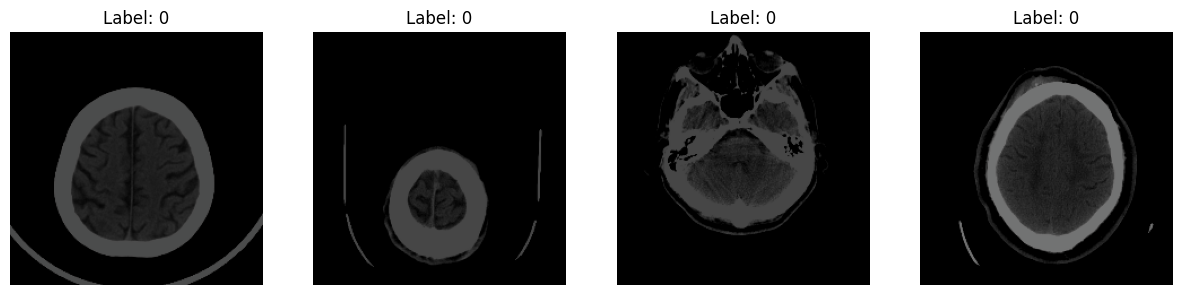

In [34]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

# Visualize random images from training dataset
print("Training Images:")
visualize_random_images(dataloader)

### Remove and clean the dataset

In [40]:
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt

def crop_brain(image, threshold=10):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold only
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Find the contours of the binary image
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(largest_contour) < 12000:
        return None
        
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image using the bounding box coordinates
    crop = image[y:y+h, x:x+w]
    
    return crop

# Define the custom Albumentations transform
class BrainCrop(A.ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        
    def apply(self, image, **params):
        return crop_brain(image)

class CLAHE(A.ImageOnlyTransform):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8), always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        
    def apply(self, image, **params):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        img_clahe = clahe.apply(gray)
        img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2BGR)
        return img_clahe

# Define the transform pipeline
transform = A.Compose([
    BrainCrop(),
    A.Resize(256, 256),  # Resize the cropped image
    CLAHE()  # Apply CLAHE filter
])


### Iterate though the files 

In [43]:
import os
import shutil

def process_images(input_dir, output_dir, transform):
    # Ensure output directory exists

    cleaned_images = 0
    remove_images = 0
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get a list of all image filenames in the input directory
    image_filenames = os.listdir(input_dir)

    # Process each image
    for filename in image_filenames:
        # Ignore non-image files
        if not (filename.endswith(".png") or filename.endswith(".jpg")):
            continue

        # Read the image
        image = cv2.imread(os.path.join(input_dir, filename))

        # Apply the transforms
        try:
            augmented_image = transform(image=image)["image"]
            cleaned_images += 1

        except Exception as e:
            remove_images += 1
            continue\
            

        # Save the preprocessed image to the output directory
        cv2.imwrite(os.path.join(output_dir, filename), augmented_image)
    print(f"Cleaned Image :{cleaned_images}")
    print(f"Removed Images: {remove_images}")

# Define the transform pipeline
transform = A.Compose([
    BrainCrop(),
    A.Resize(256, 256),  # Resize the cropped image
    CLAHE()  # Apply CLAHE filter
])

# Process the images in the 'Hemorrhage' and 'Normal' folders
process_images("stage_1_train_png_224x", "RSNA_test", transform)

Cleaned Image :424782
Removed Images: 247015


In [29]:
import os
import pandas as pd

def process_images(input_dir, Labels):
    new_labels_list = []

    # Get a list of all image filenames in the input directory
    image_filenames = os.listdir(input_dir)
    count = 0
    # Process each image
    for filename in image_filenames:
        # Ignore non-image files
        if not (filename.endswith(".png") or filename.endswith(".jpg")):
            continue

        id = filename.split('.')[0]
        
        # Fetch the 'any' value from the Labels dataframe for this ID
        label_value = Labels[Labels['Image'] == id]['any'].values[0]
        
        new_labels_list.append({'Image': id, 'any': label_value})


        count += 1
        if count >= 200:

            break

    # Convert the list to a DataFrame
    new_label_df = pd.DataFrame(new_labels_list)

    print(count)
    return new_label_df

# Load the Labels dataframe
Labels = pd.read_csv('labels/RSNA_labels.csv')

# Process the images in the 'RSNA_Processed' folder
new_label = process_images("RSNA/folder_1/", Labels)

new_label.


200


,Image,any
0,ID_00005679d,0
1,ID_0002003a8,0
2,ID_000280440,0
3,ID_00032044c,0
4,ID_000438d71,0
...,...,...
195,ID_0097c2257,0
196,ID_00987e4d3,0
197,ID_009980fa5,0
198,ID_009a767bc,1


1803    1
Name: any, dtype: int64

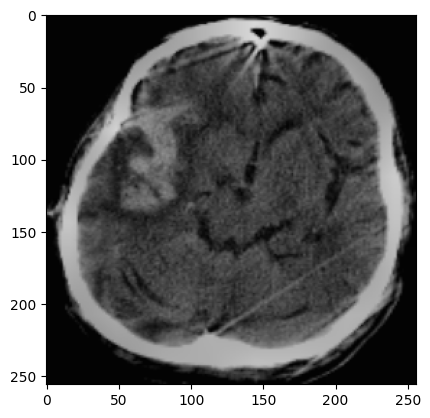

In [32]:
from PIL import Image
Labels = pd.read_csv('labels/RSNA_labels.csv')

img = Image.open(r'RSNA\\folder_1\\ID_009a767bc.png')
plt.imshow(img)
# plt.title(r'')
Labels[Labels['Image']=='ID_009a767bc']['any']

In [25]:
import os
import shutil

src_folder = 'RSNA_Processed'
dest_folder = 'RSNA'

# Ensure the destination directory exists
if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)

# List all PNG files in the source folder
all_files = [f for f in os.listdir(src_folder) if f.endswith('.png')]

# Create 5 subfolders in the destination folder
subfolders = [os.path.join(dest_folder, f'folder_{i}') for i in range(1, 6)]
for subfolder in subfolders:
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)

# Distribute files among the five folders
for i, file in enumerate(all_files):
    dest_subfolder = subfolders[i % 5]  # This will cycle through 0,1,2,3,4
    shutil.copy(os.path.join(src_folder, file), os.path.join(dest_subfolder, file))


OSError: [Errno 28] No space left on device